# Discovering Recurring Themes Among Reviews
"When you can't read every review, let a computer do it for you." Technique demonstrated for two individual restaurants.

## Imports

In [1]:
from typing import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
plt.style.use("ggplot")

%load_ext autoreload
%autoreload 1
%aimport src.Elbow

## Helper/analysis functions

In [2]:
def set_matplotlib_fontsize(DPI=72, SMALL_SIZE=17, MEDIUM_SIZE=19, BIGGER_SIZE=23):
    '''
        Convenience function for setting font sizes in figures
    '''
    plt.rc("text", usetex=True)
    plt.rc("figure", dpi=DPI)
    plt.rc("mathtext", fontset="dejavuserif")
    plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


def get_top_n_words(reviews: Iterable[str], **vectorizer_kwargs) -> pd.DataFrame:
    vectorizer = CountVectorizer(**vectorizer_kwargs).fit(reviews)
    per_token_counts = np.asarray(vectorizer.transform(reviews).sum(axis=0)).reshape(-1, 1)

    ix_to_tokens = {ix: token for token, ix in vectorizer.vocabulary_.items()}
    tokens_ordered_by_ix = [ix_to_tokens[ix] for ix in range(len(ix_to_tokens))]

    counts = pd.DataFrame(per_token_counts / len(per_token_counts),
                          index = tokens_ordered_by_ix,
                          columns=["counts_per_review"])
    return counts


def get_contrasting_token_counts(restaurant: str, 
                                 master_df: pd.DataFrame) -> pd.DataFrame:
    pos_cnts = get_top_n_words(df.query("`name` == @restaurant & stars == 5").text, 
                               max_df=0.9, min_df=0.05, stop_words = all_stop_words)

    neg_cnts = get_top_n_words(df.query("`name` == @restaurant & stars == 1").text, 
                               max_df=0.9, min_df=0.05, stop_words = all_stop_words)

    combined = pd.concat([pos_cnts, neg_cnts], axis=1)
    combined.columns = ["from 5-star reviews", "from 1-star reviews"]
    return combined

## Load data
Combined DataFrame describing businesses and reviews 

In [3]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')\
       .drop(columns=["attributes", "useful", "funny", "cool"])
df.head(3)

,business_id,name,categories,avg_stars,review_id,user_id,stars,date,text
0,-8R_-EkGpUhBk55K9Dd4mg,Sin City Thai Restaurant,"Restaurants, Thai",3.5,tSrDgb7hulEJOUbjY6uzOQ,o9D90Dr6z27JL6AlivsoFw,4,2016-07-11,I was quite fortunate to have discovered this ...
1,-8R_-EkGpUhBk55K9Dd4mg,Sin City Thai Restaurant,"Restaurants, Thai",3.5,zy9rxkBd5PRgGddrqssHqA,IcoRrRz7Uw026AwPbsA2nQ,1,2016-04-01,I ate here about a year ago and if i was revie...
2,-8R_-EkGpUhBk55K9Dd4mg,Sin City Thai Restaurant,"Restaurants, Thai",3.5,TXawcFHt5y0RDJYLxP2hiw,RVZx5g76-QzFe1rM965wAg,1,2016-01-18,Simply put the customer service here is horrib...


## Analysis for two contrasting franchises
"Fine dining" v.s. fast food; what do people say? Ignoring differences between branches, for now.

For each franchise, I counted the occurences per review\* of each unigram in 5-star and 1-star reviews, **separately**. Then, I made two plots with the most frequent words, ranked by their counts per review in 1-star and 5-star reviews, **respectively**. By looking at the top words, we can quickly see what diners are saying about each franchise.

\* normalization performed to mitigate an imbalanced number of 1-star v.s. 5-star reviews

In [4]:
gordon = "Gordon Ramsay Hell's Kitchen"
mc = "McDonald's"
all_stop_words = stopwords.words("english") + "food,restaurant,us,get,could,would".split(",")

In [5]:
set_matplotlib_fontsize(DPI = 100, SMALL_SIZE = 13, MEDIUM_SIZE = 15, BIGGER_SIZE = 17)

In [14]:
# Highly-rated restaurant 
print(df.query("`name` == @gordon")["avg_stars"].unique())

# ... versus well-known fast food brand
print(df.query("`name` == @mc")["avg_stars"].unique())

[4.5]
[1.5 2.5 3.5 2.  3. ]


In [8]:
def make_plot(cnts_df: pd.DataFrame, restaurant_name: str, top_n: int = 20, **fig_kwargs):
    fig, axes = plt.subplots(1, 2, figsize=(13, 7), sharex=True, tight_layout=True)
    fig.suptitle(f"Term Frequencies (TF) In Reviews of {restaurant_name}")
    
    cnts_df = cnts_df.sort_values("from 5-star reviews", ascending=False)
    cnts_df.iloc[:top_n].plot.barh(ax=axes[0], title="Sorted by 5-star TF, top 20")

    cnts_df = cnts_df.sort_values("from 1-star reviews", ascending=False)
    cnts_df.iloc[:top_n].plot.barh(ax=axes[1], title="Sorted by 1-star TF, top 20")

    for ax in axes:
        ax.set_xlabel("Counts Per Review")
        
    return fig, axes

Insights about Gordon Ramsay Hell's Kitchen? Key unigrams `highlighted` below.

1. Reviewers overwhelmingly like the restaurant, as evident by the higher counts per 5-star review for all words displayed.

2. Reviewers who like the restaurant probably really love the food; the word `delicious` appear on average more than once in each 5-star review. Also, it seems that desserts are an attraction as well: `toffee` and `pudding` are getting top mentions.

3. 1-star reviews are possibly due to `service` and the `reservation` process; there may also be some concern about `time`. 

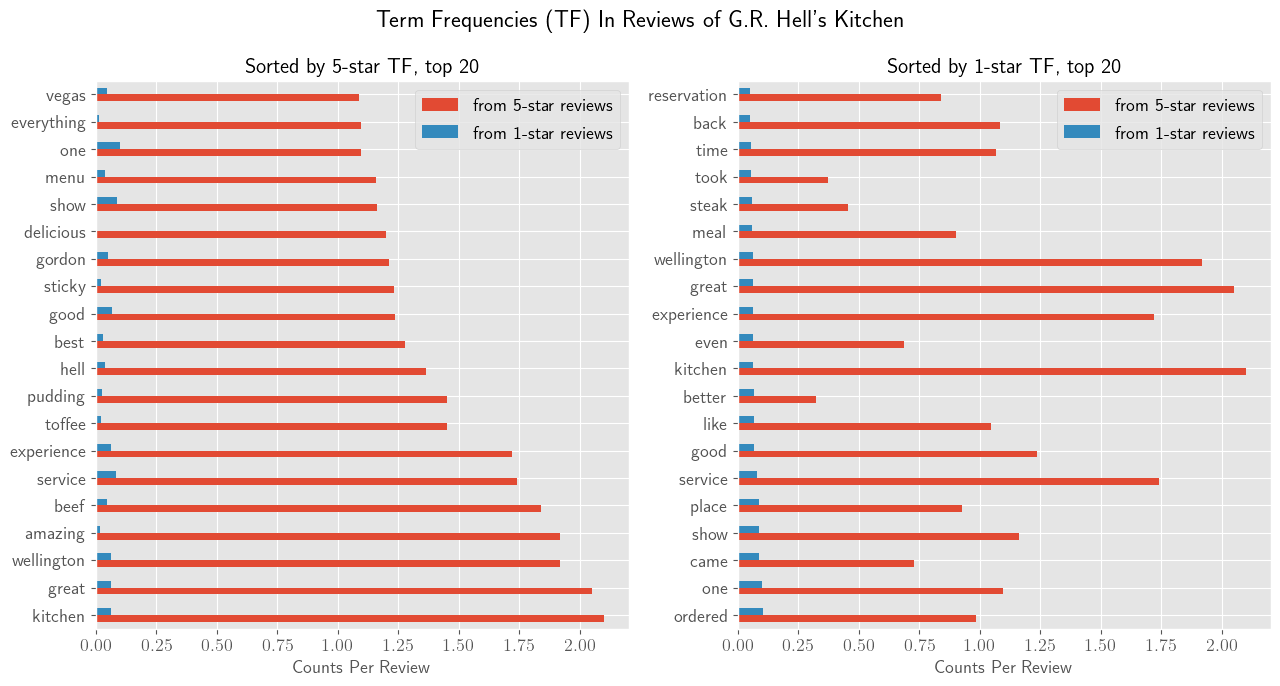

In [9]:
gordon_cnts = get_contrasting_token_counts(gordon, df)
fig, axes = make_plot(gordon_cnts, "G.R. Hell's Kitchen")

In [10]:
fig.clf()

Insights about McDonald's in Las Vegas? Key unigrams `highlighted` below.

1. Reviewers overwhelmingly "dislike" the franchise, as evident by the higher counts per 1-star review for all words displayed.

2. 5-star reviewers were probably impressed by staff's `friendly` behavior, and how `clean`/`nice` the branch was. However, there is no mention of specific food items, unlike for Hell Kitchen.

3. It's doubtful whether the positive behavior and environment are universal across branches. 1-star reviewers mention the word `manager` in 1 out of 2 reviews on average; escalations are common and that's not a good sign.

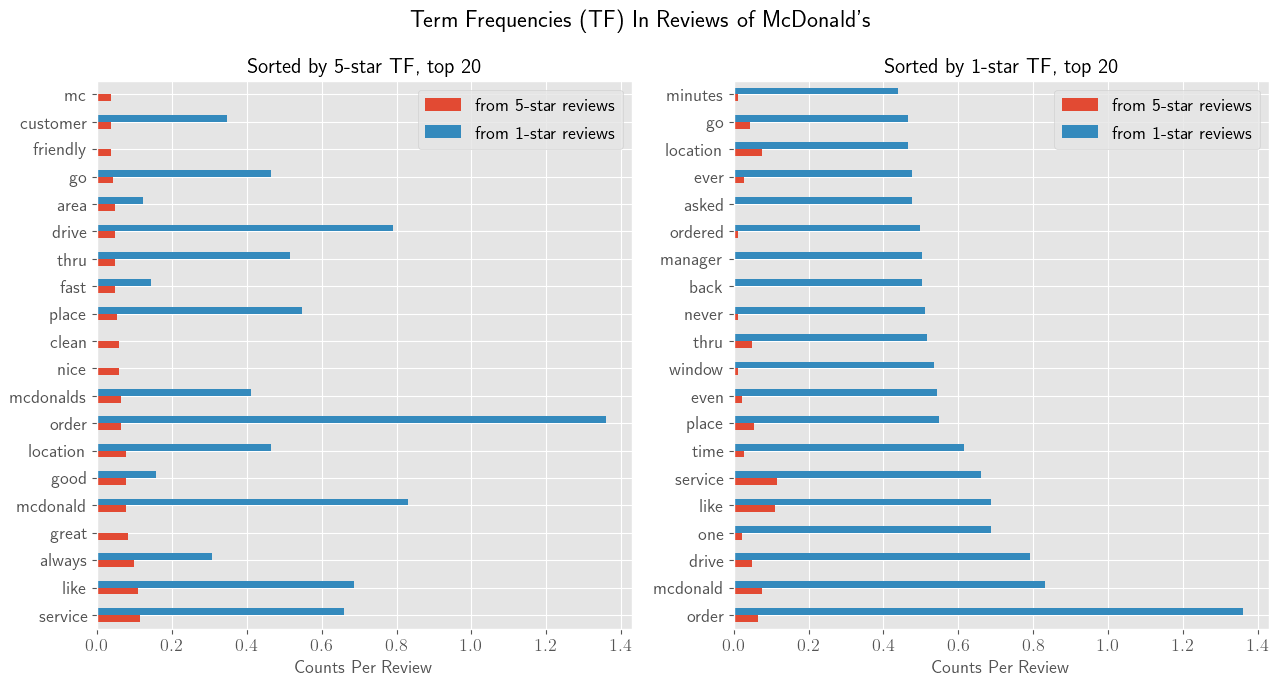

In [12]:
mc_cnts = get_contrasting_token_counts(mc, df)
fig, axes = make_plot(mc_cnts, mc)

## Summary and Extensions
In short, we can quickly get an idea of what diners are saying about restaurants, even without machine learning algorithms.

How can the analysis be improved? Here are some ideas.
1. Incorporate bigrams or even trigrams
2. Design a data-driven way to determine `min_df` and `max_df`
3. Cluster reviews using k-means and discover themes in a more fine-grained manner. I strongly advise against doing so in TF-IDF space due to the curse of dimensionality. Should preprocess with PCA or seek a more compact embedding (e.g. `word2vec`) to begin with.